In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.read_normalize import read_normalize
from model.seg_model.unet import unet
# from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from dataloader.parallel_vary_loader import threads_scene_dset_vary
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
'''--------- data loading --------'''
### ------ 1. training data loading: from scenes path ----- ### 
scene_list, truth_list = read_normalize(paths_as=config.paths_as, \
                            paths_des=config.paths_des, paths_truth=config.paths_truth)
tra_dset = threads_scene_dset_vary(scene_list[0:15], \
                            truth_list[0:15], transforms=config.transforms_tra, num_thread=30)

## ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in config.paths_patch_val]
val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())


size of training data: 450
size of val data: 250


In [4]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)


In [5]:
## ------------ Model ------------ ##
## -------- 1. single scale -------
model = unet(num_bands=4, num_classes=2).to(device)
# model = deeplabv3plus(num_bands=4, num_classes=2).to(device)
# model = deeplabv3plus_imp(num_bands=4, num_classes=2).to(device)


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                            mode='min', factor=0.5, patience=10)
                                            

In [7]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_batch = config.label_smooth(y_batch, 0.1)         ### --- label smoothing
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                            optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)    # dynamic adjust learning rate

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch[2].to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, \
                                                        x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patch = torch.unsqueeze(patches[2], 0).to(device)   # 
            truth = truth.to(device)
            pred = model(patch)
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patch_list = [patch, truth, pred]
            # ---- plot result
            plt.figure(figsize=(10,4))
            patches_name = ['input','truth','pred']
            clip_list = [2,0,0]
            col_bands_list = [(2,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patch_list, img_name_list=patches_name, \
                                        clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics
    

Ep1: tra-> Loss:0.550,Oa:0.773,Miou:0.645, val-> Loss:0.555,Oa:0.769,Miou:0.586,time:3.0s
Ep2: tra-> Loss:0.532,Oa:0.824,Miou:0.661, val-> Loss:0.300,Oa:0.901,Miou:0.841,time:2.5s
Ep3: tra-> Loss:0.524,Oa:0.828,Miou:0.690, val-> Loss:0.367,Oa:0.862,Miou:0.778,time:2.6s
Ep4: tra-> Loss:0.505,Oa:0.828,Miou:0.703, val-> Loss:0.292,Oa:0.909,Miou:0.841,time:2.5s
Ep5: tra-> Loss:0.483,Oa:0.868,Miou:0.758, val-> Loss:0.286,Oa:0.898,Miou:0.829,time:2.5s
Ep6: tra-> Loss:0.484,Oa:0.855,Miou:0.720, val-> Loss:0.281,Oa:0.897,Miou:0.830,time:2.5s
Ep7: tra-> Loss:0.506,Oa:0.855,Miou:0.715, val-> Loss:0.308,Oa:0.883,Miou:0.811,time:2.5s
Ep8: tra-> Loss:0.493,Oa:0.856,Miou:0.724, val-> Loss:0.371,Oa:0.880,Miou:0.618,time:2.5s
Ep9: tra-> Loss:0.496,Oa:0.853,Miou:0.725, val-> Loss:0.286,Oa:0.878,Miou:0.807,time:2.5s
Ep10: tra-> Loss:0.502,Oa:0.843,Miou:0.719, val-> Loss:0.421,Oa:0.870,Miou:0.520,time:2.5s


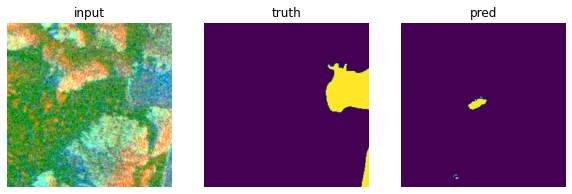

Ep11: tra-> Loss:0.467,Oa:0.885,Miou:0.774, val-> Loss:0.316,Oa:0.890,Miou:0.722,time:2.6s
Ep12: tra-> Loss:0.460,Oa:0.887,Miou:0.779, val-> Loss:0.346,Oa:0.879,Miou:0.700,time:2.5s
Ep13: tra-> Loss:0.452,Oa:0.889,Miou:0.795, val-> Loss:0.314,Oa:0.885,Miou:0.722,time:2.5s
Ep14: tra-> Loss:0.454,Oa:0.894,Miou:0.791, val-> Loss:0.360,Oa:0.879,Miou:0.656,time:2.5s
Ep15: tra-> Loss:0.456,Oa:0.891,Miou:0.787, val-> Loss:0.279,Oa:0.889,Miou:0.774,time:2.6s
Ep16: tra-> Loss:0.437,Oa:0.906,Miou:0.809, val-> Loss:0.274,Oa:0.882,Miou:0.808,time:2.6s
Ep17: tra-> Loss:0.431,Oa:0.909,Miou:0.821, val-> Loss:0.319,Oa:0.875,Miou:0.775,time:2.5s
Ep18: tra-> Loss:0.404,Oa:0.931,Miou:0.868, val-> Loss:0.291,Oa:0.876,Miou:0.777,time:2.5s
Ep19: tra-> Loss:0.422,Oa:0.917,Miou:0.838, val-> Loss:0.335,Oa:0.866,Miou:0.703,time:2.5s
Ep20: tra-> Loss:0.432,Oa:0.903,Miou:0.815, val-> Loss:0.619,Oa:0.642,Miou:0.480,time:2.5s


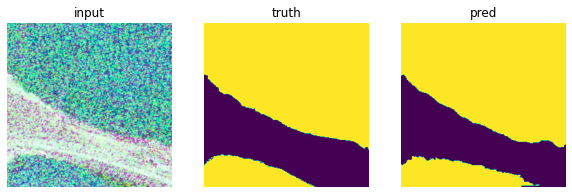

Ep21: tra-> Loss:0.482,Oa:0.870,Miou:0.752, val-> Loss:0.280,Oa:0.876,Miou:0.802,time:2.6s
Ep22: tra-> Loss:0.429,Oa:0.892,Miou:0.809, val-> Loss:0.440,Oa:0.850,Miou:0.582,time:2.6s
Ep23: tra-> Loss:0.404,Oa:0.936,Miou:0.871, val-> Loss:0.345,Oa:0.870,Miou:0.701,time:2.5s
Ep24: tra-> Loss:0.396,Oa:0.943,Miou:0.883, val-> Loss:0.273,Oa:0.902,Miou:0.794,time:2.6s
Ep25: tra-> Loss:0.390,Oa:0.946,Miou:0.881, val-> Loss:0.263,Oa:0.906,Miou:0.813,time:2.6s
Ep26: tra-> Loss:0.377,Oa:0.954,Miou:0.909, val-> Loss:0.359,Oa:0.862,Miou:0.691,time:2.5s
Ep27: tra-> Loss:0.388,Oa:0.943,Miou:0.888, val-> Loss:0.261,Oa:0.908,Miou:0.807,time:2.6s
Ep28: tra-> Loss:0.391,Oa:0.948,Miou:0.884, val-> Loss:0.348,Oa:0.855,Miou:0.680,time:2.6s
Ep29: tra-> Loss:0.387,Oa:0.941,Miou:0.891, val-> Loss:0.245,Oa:0.913,Miou:0.833,time:2.6s
Ep30: tra-> Loss:0.405,Oa:0.923,Miou:0.865, val-> Loss:0.263,Oa:0.901,Miou:0.841,time:2.6s


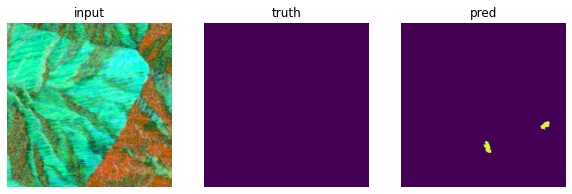

Ep31: tra-> Loss:0.398,Oa:0.943,Miou:0.885, val-> Loss:0.427,Oa:0.829,Miou:0.632,time:2.6s
Ep32: tra-> Loss:0.387,Oa:0.947,Miou:0.894, val-> Loss:0.278,Oa:0.887,Miou:0.782,time:2.6s
Ep33: tra-> Loss:0.386,Oa:0.946,Miou:0.894, val-> Loss:0.392,Oa:0.857,Miou:0.647,time:2.6s
Ep34: tra-> Loss:0.371,Oa:0.957,Miou:0.915, val-> Loss:0.257,Oa:0.894,Miou:0.819,time:2.6s
Ep35: tra-> Loss:0.395,Oa:0.935,Miou:0.882, val-> Loss:0.300,Oa:0.881,Miou:0.752,time:2.6s
Ep36: tra-> Loss:0.382,Oa:0.954,Miou:0.900, val-> Loss:0.479,Oa:0.801,Miou:0.539,time:2.5s
Ep37: tra-> Loss:0.396,Oa:0.937,Miou:0.880, val-> Loss:0.368,Oa:0.797,Miou:0.681,time:2.6s
Ep38: tra-> Loss:0.402,Oa:0.934,Miou:0.872, val-> Loss:0.253,Oa:0.891,Miou:0.827,time:2.5s
Ep39: tra-> Loss:0.403,Oa:0.935,Miou:0.871, val-> Loss:0.242,Oa:0.916,Miou:0.857,time:2.5s
Ep40: tra-> Loss:0.382,Oa:0.943,Miou:0.897, val-> Loss:0.252,Oa:0.906,Miou:0.821,time:2.6s


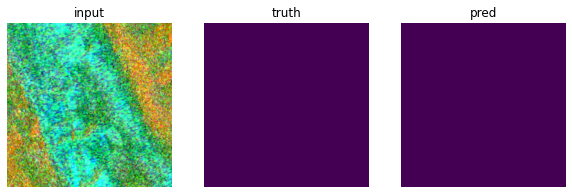

Ep41: tra-> Loss:0.380,Oa:0.957,Miou:0.908, val-> Loss:0.266,Oa:0.902,Miou:0.833,time:2.6s
Ep42: tra-> Loss:0.381,Oa:0.955,Miou:0.910, val-> Loss:0.311,Oa:0.879,Miou:0.806,time:2.5s
Ep43: tra-> Loss:0.392,Oa:0.945,Miou:0.889, val-> Loss:0.361,Oa:0.878,Miou:0.689,time:2.6s
Ep44: tra-> Loss:0.368,Oa:0.961,Miou:0.922, val-> Loss:0.396,Oa:0.845,Miou:0.667,time:2.6s
Ep45: tra-> Loss:0.376,Oa:0.959,Miou:0.914, val-> Loss:0.340,Oa:0.861,Miou:0.716,time:2.6s
Ep46: tra-> Loss:0.377,Oa:0.956,Miou:0.910, val-> Loss:0.234,Oa:0.904,Miou:0.846,time:2.6s
Ep47: tra-> Loss:0.379,Oa:0.955,Miou:0.910, val-> Loss:0.255,Oa:0.905,Miou:0.844,time:2.6s
Ep48: tra-> Loss:0.391,Oa:0.944,Miou:0.889, val-> Loss:0.224,Oa:0.921,Miou:0.866,time:2.6s
Ep49: tra-> Loss:0.371,Oa:0.961,Miou:0.918, val-> Loss:0.256,Oa:0.902,Miou:0.830,time:2.6s
Ep50: tra-> Loss:0.387,Oa:0.952,Miou:0.898, val-> Loss:0.241,Oa:0.930,Miou:0.840,time:2.6s


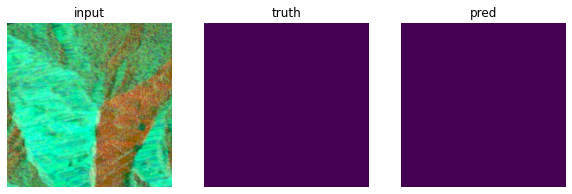

Ep51: tra-> Loss:0.374,Oa:0.959,Miou:0.917, val-> Loss:0.233,Oa:0.917,Miou:0.852,time:2.6s
Ep52: tra-> Loss:0.374,Oa:0.945,Miou:0.906, val-> Loss:0.244,Oa:0.909,Miou:0.826,time:2.6s
Ep53: tra-> Loss:0.361,Oa:0.970,Miou:0.939, val-> Loss:0.269,Oa:0.903,Miou:0.794,time:2.6s
Ep54: tra-> Loss:0.399,Oa:0.937,Miou:0.871, val-> Loss:0.635,Oa:0.680,Miou:0.393,time:2.5s
Ep55: tra-> Loss:0.455,Oa:0.896,Miou:0.791, val-> Loss:0.296,Oa:0.893,Miou:0.744,time:2.6s
Ep56: tra-> Loss:0.387,Oa:0.948,Miou:0.895, val-> Loss:0.240,Oa:0.912,Miou:0.854,time:2.5s
Ep57: tra-> Loss:0.392,Oa:0.943,Miou:0.885, val-> Loss:0.301,Oa:0.876,Miou:0.766,time:2.6s
Ep58: tra-> Loss:0.376,Oa:0.955,Miou:0.913, val-> Loss:0.365,Oa:0.879,Miou:0.708,time:2.6s
Ep59: tra-> Loss:0.388,Oa:0.949,Miou:0.902, val-> Loss:0.241,Oa:0.903,Miou:0.845,time:2.6s
Ep60: tra-> Loss:0.369,Oa:0.958,Miou:0.924, val-> Loss:0.216,Oa:0.927,Miou:0.857,time:2.6s


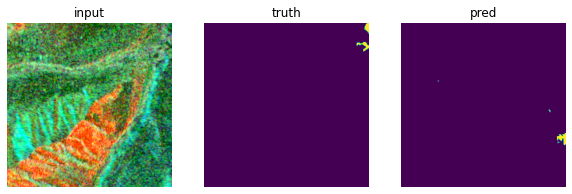

Ep61: tra-> Loss:0.379,Oa:0.954,Miou:0.913, val-> Loss:0.296,Oa:0.888,Miou:0.772,time:2.6s
Ep62: tra-> Loss:0.397,Oa:0.935,Miou:0.885, val-> Loss:0.321,Oa:0.867,Miou:0.729,time:2.6s
Ep63: tra-> Loss:0.370,Oa:0.963,Miou:0.925, val-> Loss:0.292,Oa:0.900,Miou:0.762,time:2.5s
Ep64: tra-> Loss:0.367,Oa:0.964,Miou:0.928, val-> Loss:0.211,Oa:0.931,Miou:0.884,time:2.6s
Ep65: tra-> Loss:0.360,Oa:0.970,Miou:0.940, val-> Loss:0.278,Oa:0.908,Miou:0.789,time:2.6s
Ep66: tra-> Loss:0.363,Oa:0.968,Miou:0.932, val-> Loss:0.231,Oa:0.929,Miou:0.855,time:2.6s
Ep67: tra-> Loss:0.362,Oa:0.968,Miou:0.937, val-> Loss:0.253,Oa:0.916,Miou:0.827,time:2.6s
Ep68: tra-> Loss:0.374,Oa:0.964,Miou:0.919, val-> Loss:0.369,Oa:0.861,Miou:0.687,time:2.6s
Ep69: tra-> Loss:0.361,Oa:0.969,Miou:0.940, val-> Loss:0.242,Oa:0.925,Miou:0.834,time:2.6s
Ep70: tra-> Loss:0.361,Oa:0.969,Miou:0.939, val-> Loss:0.264,Oa:0.917,Miou:0.811,time:2.6s


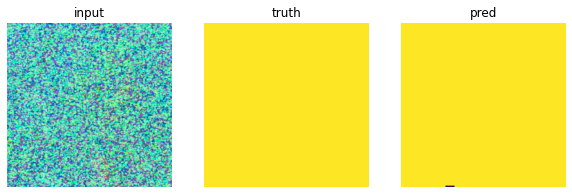

Ep71: tra-> Loss:0.368,Oa:0.963,Miou:0.928, val-> Loss:0.296,Oa:0.897,Miou:0.759,time:2.6s
Ep72: tra-> Loss:0.382,Oa:0.965,Miou:0.915, val-> Loss:0.228,Oa:0.923,Miou:0.866,time:2.5s
Ep73: tra-> Loss:0.360,Oa:0.975,Miou:0.944, val-> Loss:0.223,Oa:0.928,Miou:0.855,time:2.6s
Ep74: tra-> Loss:0.358,Oa:0.974,Miou:0.944, val-> Loss:0.256,Oa:0.916,Miou:0.811,time:2.6s
Ep75: tra-> Loss:0.377,Oa:0.963,Miou:0.912, val-> Loss:0.247,Oa:0.906,Miou:0.838,time:2.6s
Ep76: tra-> Loss:0.369,Oa:0.963,Miou:0.923, val-> Loss:0.231,Oa:0.923,Miou:0.858,time:2.6s
Ep77: tra-> Loss:0.361,Oa:0.968,Miou:0.934, val-> Loss:0.361,Oa:0.860,Miou:0.707,time:2.6s
Ep78: tra-> Loss:0.364,Oa:0.967,Miou:0.937, val-> Loss:0.196,Oa:0.946,Miou:0.899,time:2.6s
Ep79: tra-> Loss:0.393,Oa:0.946,Miou:0.890, val-> Loss:0.296,Oa:0.885,Miou:0.815,time:2.6s
Ep80: tra-> Loss:0.370,Oa:0.952,Miou:0.915, val-> Loss:0.208,Oa:0.927,Miou:0.878,time:2.6s


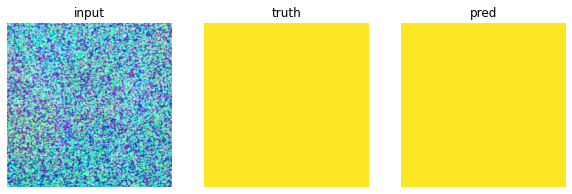

Ep81: tra-> Loss:0.355,Oa:0.974,Miou:0.947, val-> Loss:0.214,Oa:0.931,Miou:0.870,time:2.6s
Ep82: tra-> Loss:0.360,Oa:0.973,Miou:0.944, val-> Loss:0.210,Oa:0.928,Miou:0.881,time:2.6s
Ep83: tra-> Loss:0.357,Oa:0.973,Miou:0.944, val-> Loss:0.207,Oa:0.936,Miou:0.886,time:2.6s
Ep84: tra-> Loss:0.354,Oa:0.975,Miou:0.948, val-> Loss:0.205,Oa:0.934,Miou:0.884,time:2.6s
Ep85: tra-> Loss:0.361,Oa:0.968,Miou:0.935, val-> Loss:0.244,Oa:0.906,Miou:0.850,time:2.6s
Ep86: tra-> Loss:0.365,Oa:0.968,Miou:0.933, val-> Loss:0.361,Oa:0.868,Miou:0.704,time:2.6s
Ep87: tra-> Loss:0.361,Oa:0.972,Miou:0.942, val-> Loss:0.223,Oa:0.926,Miou:0.864,time:2.6s
Ep88: tra-> Loss:0.365,Oa:0.967,Miou:0.933, val-> Loss:0.222,Oa:0.929,Miou:0.869,time:2.6s
Ep89: tra-> Loss:0.377,Oa:0.954,Miou:0.915, val-> Loss:0.256,Oa:0.895,Miou:0.828,time:2.6s
Ep90: tra-> Loss:0.361,Oa:0.971,Miou:0.940, val-> Loss:0.417,Oa:0.856,Miou:0.660,time:2.6s


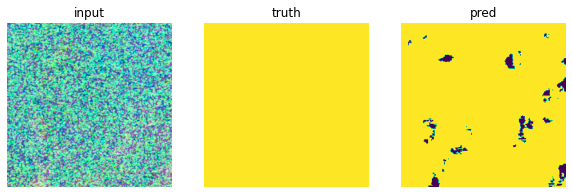

Ep91: tra-> Loss:0.377,Oa:0.955,Miou:0.917, val-> Loss:0.239,Oa:0.911,Miou:0.855,time:2.6s
Ep92: tra-> Loss:0.370,Oa:0.959,Miou:0.925, val-> Loss:0.228,Oa:0.922,Miou:0.873,time:2.6s
Ep93: tra-> Loss:0.359,Oa:0.969,Miou:0.935, val-> Loss:0.206,Oa:0.930,Miou:0.883,time:2.6s
Ep94: tra-> Loss:0.368,Oa:0.962,Miou:0.927, val-> Loss:0.277,Oa:0.917,Miou:0.788,time:2.6s
Ep95: tra-> Loss:0.372,Oa:0.962,Miou:0.924, val-> Loss:0.221,Oa:0.925,Miou:0.866,time:2.6s
Ep96: tra-> Loss:0.365,Oa:0.966,Miou:0.931, val-> Loss:0.258,Oa:0.915,Miou:0.823,time:2.6s
Ep97: tra-> Loss:0.360,Oa:0.974,Miou:0.943, val-> Loss:0.240,Oa:0.922,Miou:0.849,time:2.6s
Ep98: tra-> Loss:0.353,Oa:0.975,Miou:0.951, val-> Loss:0.234,Oa:0.924,Miou:0.852,time:2.6s
Ep99: tra-> Loss:0.349,Oa:0.980,Miou:0.958, val-> Loss:0.221,Oa:0.923,Miou:0.863,time:2.6s
Ep100: tra-> Loss:0.360,Oa:0.952,Miou:0.923, val-> Loss:0.207,Oa:0.934,Miou:0.885,time:2.6s


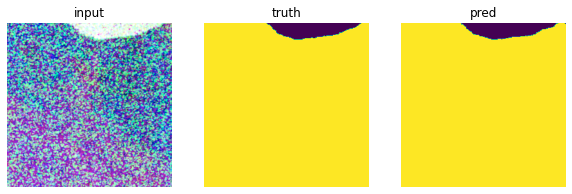

Ep101: tra-> Loss:0.356,Oa:0.974,Miou:0.948, val-> Loss:0.209,Oa:0.933,Miou:0.886,time:2.6s
Ep102: tra-> Loss:0.360,Oa:0.968,Miou:0.930, val-> Loss:0.218,Oa:0.926,Miou:0.876,time:2.6s
Ep103: tra-> Loss:0.355,Oa:0.973,Miou:0.947, val-> Loss:0.212,Oa:0.929,Miou:0.877,time:2.6s
Ep104: tra-> Loss:0.357,Oa:0.974,Miou:0.948, val-> Loss:0.236,Oa:0.919,Miou:0.848,time:2.6s
Ep105: tra-> Loss:0.357,Oa:0.976,Miou:0.944, val-> Loss:0.226,Oa:0.922,Miou:0.868,time:2.6s
Ep106: tra-> Loss:0.357,Oa:0.974,Miou:0.946, val-> Loss:0.232,Oa:0.920,Miou:0.857,time:2.6s
Ep107: tra-> Loss:0.355,Oa:0.977,Miou:0.952, val-> Loss:0.233,Oa:0.926,Miou:0.858,time:2.5s
Ep108: tra-> Loss:0.349,Oa:0.980,Miou:0.959, val-> Loss:0.208,Oa:0.933,Miou:0.882,time:2.6s
Ep109: tra-> Loss:0.351,Oa:0.970,Miou:0.947, val-> Loss:0.213,Oa:0.931,Miou:0.875,time:2.6s
Ep110: tra-> Loss:0.353,Oa:0.978,Miou:0.953, val-> Loss:0.215,Oa:0.928,Miou:0.880,time:2.6s


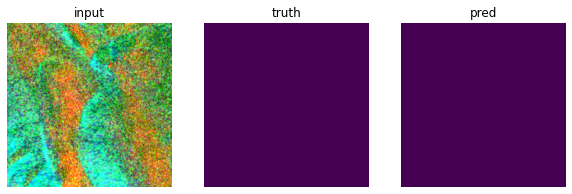

Ep111: tra-> Loss:0.356,Oa:0.972,Miou:0.945, val-> Loss:0.207,Oa:0.934,Miou:0.883,time:2.6s
Ep112: tra-> Loss:0.357,Oa:0.974,Miou:0.946, val-> Loss:0.209,Oa:0.935,Miou:0.890,time:2.6s
Ep113: tra-> Loss:0.358,Oa:0.974,Miou:0.942, val-> Loss:0.203,Oa:0.935,Miou:0.892,time:2.6s
Ep114: tra-> Loss:0.358,Oa:0.973,Miou:0.945, val-> Loss:0.274,Oa:0.910,Miou:0.801,time:2.6s
Ep115: tra-> Loss:0.355,Oa:0.975,Miou:0.939, val-> Loss:0.216,Oa:0.929,Miou:0.874,time:2.6s
Ep116: tra-> Loss:0.358,Oa:0.972,Miou:0.946, val-> Loss:0.221,Oa:0.930,Miou:0.868,time:2.6s
Ep117: tra-> Loss:0.352,Oa:0.959,Miou:0.936, val-> Loss:0.219,Oa:0.922,Miou:0.864,time:2.6s
Ep118: tra-> Loss:0.358,Oa:0.971,Miou:0.944, val-> Loss:0.271,Oa:0.911,Miou:0.794,time:2.6s
Ep119: tra-> Loss:0.356,Oa:0.976,Miou:0.950, val-> Loss:0.207,Oa:0.937,Miou:0.888,time:2.6s
Ep120: tra-> Loss:0.352,Oa:0.980,Miou:0.957, val-> Loss:0.208,Oa:0.938,Miou:0.886,time:2.6s


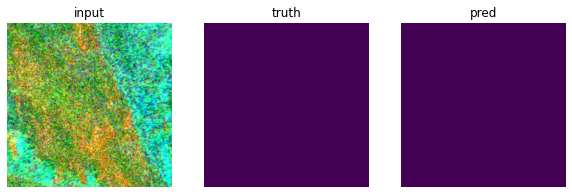

Ep121: tra-> Loss:0.352,Oa:0.978,Miou:0.954, val-> Loss:0.214,Oa:0.927,Miou:0.876,time:2.6s
Ep122: tra-> Loss:0.348,Oa:0.980,Miou:0.959, val-> Loss:0.218,Oa:0.918,Miou:0.865,time:2.6s
Ep123: tra-> Loss:0.354,Oa:0.976,Miou:0.950, val-> Loss:0.205,Oa:0.937,Miou:0.889,time:2.6s
Ep124: tra-> Loss:0.347,Oa:0.980,Miou:0.961, val-> Loss:0.206,Oa:0.938,Miou:0.885,time:2.6s
Ep125: tra-> Loss:0.349,Oa:0.981,Miou:0.961, val-> Loss:0.211,Oa:0.933,Miou:0.884,time:2.6s
Ep126: tra-> Loss:0.363,Oa:0.969,Miou:0.941, val-> Loss:0.219,Oa:0.932,Miou:0.871,time:2.6s
Ep127: tra-> Loss:0.368,Oa:0.964,Miou:0.931, val-> Loss:0.215,Oa:0.928,Miou:0.878,time:2.6s
Ep128: tra-> Loss:0.353,Oa:0.978,Miou:0.952, val-> Loss:0.213,Oa:0.935,Miou:0.877,time:2.6s
Ep129: tra-> Loss:0.348,Oa:0.981,Miou:0.961, val-> Loss:0.225,Oa:0.918,Miou:0.868,time:2.6s
Ep130: tra-> Loss:0.360,Oa:0.970,Miou:0.943, val-> Loss:0.207,Oa:0.936,Miou:0.885,time:2.6s


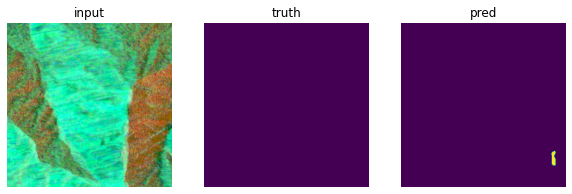

Ep131: tra-> Loss:0.360,Oa:0.972,Miou:0.945, val-> Loss:0.213,Oa:0.928,Miou:0.880,time:2.6s
Ep132: tra-> Loss:0.359,Oa:0.969,Miou:0.942, val-> Loss:0.217,Oa:0.928,Miou:0.875,time:2.6s
Ep133: tra-> Loss:0.355,Oa:0.973,Miou:0.949, val-> Loss:0.200,Oa:0.936,Miou:0.892,time:2.6s
Ep134: tra-> Loss:0.357,Oa:0.975,Miou:0.948, val-> Loss:0.205,Oa:0.937,Miou:0.889,time:2.6s
Ep135: tra-> Loss:0.357,Oa:0.975,Miou:0.946, val-> Loss:0.209,Oa:0.936,Miou:0.889,time:2.6s
Ep136: tra-> Loss:0.356,Oa:0.975,Miou:0.947, val-> Loss:0.213,Oa:0.932,Miou:0.882,time:2.6s
Ep137: tra-> Loss:0.360,Oa:0.973,Miou:0.941, val-> Loss:0.216,Oa:0.934,Miou:0.878,time:2.6s
Ep138: tra-> Loss:0.358,Oa:0.973,Miou:0.942, val-> Loss:0.213,Oa:0.930,Miou:0.883,time:2.5s
Ep139: tra-> Loss:0.350,Oa:0.976,Miou:0.954, val-> Loss:0.209,Oa:0.936,Miou:0.884,time:2.5s
Ep140: tra-> Loss:0.349,Oa:0.979,Miou:0.959, val-> Loss:0.213,Oa:0.932,Miou:0.878,time:2.6s


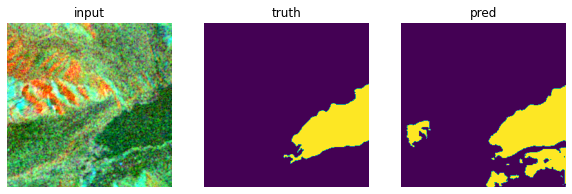

Ep141: tra-> Loss:0.352,Oa:0.975,Miou:0.950, val-> Loss:0.225,Oa:0.927,Miou:0.862,time:2.6s
Ep142: tra-> Loss:0.350,Oa:0.972,Miou:0.950, val-> Loss:0.216,Oa:0.930,Miou:0.877,time:2.5s
Ep143: tra-> Loss:0.350,Oa:0.978,Miou:0.957, val-> Loss:0.208,Oa:0.934,Miou:0.886,time:2.6s
Ep144: tra-> Loss:0.351,Oa:0.978,Miou:0.953, val-> Loss:0.217,Oa:0.932,Miou:0.874,time:2.6s
Ep145: tra-> Loss:0.346,Oa:0.982,Miou:0.962, val-> Loss:0.218,Oa:0.929,Miou:0.874,time:2.6s
Ep146: tra-> Loss:0.356,Oa:0.974,Miou:0.948, val-> Loss:0.216,Oa:0.930,Miou:0.878,time:2.6s
Ep147: tra-> Loss:0.352,Oa:0.976,Miou:0.952, val-> Loss:0.217,Oa:0.929,Miou:0.877,time:2.6s
Ep148: tra-> Loss:0.353,Oa:0.976,Miou:0.947, val-> Loss:0.213,Oa:0.932,Miou:0.881,time:2.6s
Ep149: tra-> Loss:0.350,Oa:0.978,Miou:0.956, val-> Loss:0.214,Oa:0.931,Miou:0.880,time:2.6s
Ep150: tra-> Loss:0.351,Oa:0.979,Miou:0.958, val-> Loss:0.215,Oa:0.931,Miou:0.878,time:2.6s


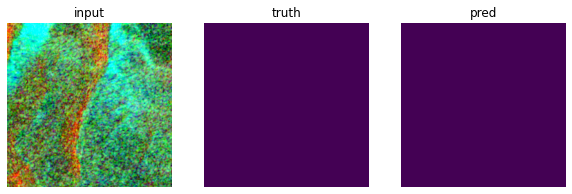

Ep151: tra-> Loss:0.351,Oa:0.979,Miou:0.956, val-> Loss:0.224,Oa:0.926,Miou:0.864,time:2.6s
Ep152: tra-> Loss:0.349,Oa:0.979,Miou:0.957, val-> Loss:0.211,Oa:0.932,Miou:0.883,time:2.6s
Ep153: tra-> Loss:0.348,Oa:0.979,Miou:0.960, val-> Loss:0.210,Oa:0.934,Miou:0.883,time:2.6s
Ep154: tra-> Loss:0.344,Oa:0.984,Miou:0.966, val-> Loss:0.213,Oa:0.930,Miou:0.880,time:2.6s
Ep155: tra-> Loss:0.353,Oa:0.976,Miou:0.954, val-> Loss:0.213,Oa:0.930,Miou:0.879,time:2.6s
Ep156: tra-> Loss:0.354,Oa:0.976,Miou:0.952, val-> Loss:0.215,Oa:0.930,Miou:0.879,time:2.6s
Ep157: tra-> Loss:0.357,Oa:0.971,Miou:0.944, val-> Loss:0.220,Oa:0.930,Miou:0.873,time:2.6s
Ep158: tra-> Loss:0.357,Oa:0.973,Miou:0.948, val-> Loss:0.236,Oa:0.922,Miou:0.851,time:2.6s
Ep159: tra-> Loss:0.355,Oa:0.973,Miou:0.946, val-> Loss:0.231,Oa:0.920,Miou:0.854,time:2.6s
Ep160: tra-> Loss:0.356,Oa:0.977,Miou:0.946, val-> Loss:0.232,Oa:0.923,Miou:0.854,time:2.6s


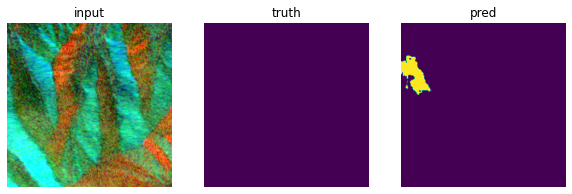

Ep161: tra-> Loss:0.349,Oa:0.980,Miou:0.958, val-> Loss:0.217,Oa:0.929,Miou:0.877,time:2.6s
Ep162: tra-> Loss:0.347,Oa:0.981,Miou:0.961, val-> Loss:0.221,Oa:0.929,Miou:0.866,time:2.6s
Ep163: tra-> Loss:0.345,Oa:0.983,Miou:0.965, val-> Loss:0.229,Oa:0.926,Miou:0.856,time:2.6s
Ep164: tra-> Loss:0.351,Oa:0.978,Miou:0.956, val-> Loss:0.212,Oa:0.930,Miou:0.882,time:2.6s
Ep165: tra-> Loss:0.353,Oa:0.977,Miou:0.953, val-> Loss:0.207,Oa:0.936,Miou:0.888,time:2.6s
Ep166: tra-> Loss:0.346,Oa:0.983,Miou:0.964, val-> Loss:0.208,Oa:0.935,Miou:0.887,time:2.6s
Ep167: tra-> Loss:0.347,Oa:0.982,Miou:0.960, val-> Loss:0.208,Oa:0.934,Miou:0.886,time:2.6s
Ep168: tra-> Loss:0.354,Oa:0.974,Miou:0.947, val-> Loss:0.216,Oa:0.933,Miou:0.874,time:2.6s
Ep169: tra-> Loss:0.352,Oa:0.976,Miou:0.952, val-> Loss:0.226,Oa:0.929,Miou:0.862,time:2.6s
Ep170: tra-> Loss:0.351,Oa:0.978,Miou:0.955, val-> Loss:0.223,Oa:0.929,Miou:0.866,time:2.6s


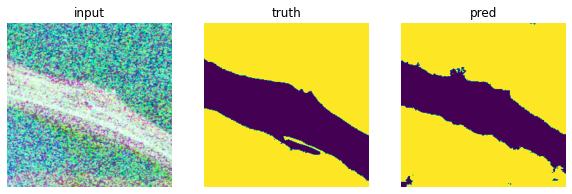

Ep171: tra-> Loss:0.349,Oa:0.978,Miou:0.956, val-> Loss:0.219,Oa:0.931,Miou:0.872,time:2.6s
Ep172: tra-> Loss:0.349,Oa:0.980,Miou:0.959, val-> Loss:0.220,Oa:0.930,Miou:0.869,time:2.6s
Ep173: tra-> Loss:0.350,Oa:0.977,Miou:0.956, val-> Loss:0.223,Oa:0.931,Miou:0.865,time:2.6s
Ep174: tra-> Loss:0.345,Oa:0.983,Miou:0.964, val-> Loss:0.223,Oa:0.929,Miou:0.864,time:2.5s
Ep175: tra-> Loss:0.346,Oa:0.983,Miou:0.963, val-> Loss:0.220,Oa:0.930,Miou:0.867,time:2.6s
Ep176: tra-> Loss:0.354,Oa:0.980,Miou:0.955, val-> Loss:0.220,Oa:0.930,Miou:0.869,time:2.6s
Ep177: tra-> Loss:0.352,Oa:0.975,Miou:0.953, val-> Loss:0.219,Oa:0.930,Miou:0.872,time:2.6s
Ep178: tra-> Loss:0.353,Oa:0.973,Miou:0.948, val-> Loss:0.219,Oa:0.930,Miou:0.870,time:2.6s
Ep179: tra-> Loss:0.345,Oa:0.984,Miou:0.965, val-> Loss:0.218,Oa:0.931,Miou:0.871,time:2.6s
Ep180: tra-> Loss:0.350,Oa:0.981,Miou:0.959, val-> Loss:0.215,Oa:0.931,Miou:0.876,time:2.6s


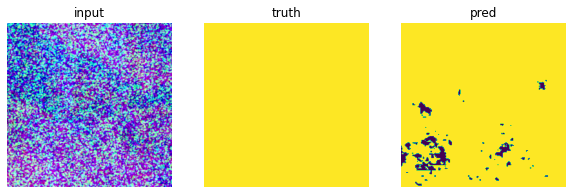

Ep181: tra-> Loss:0.349,Oa:0.973,Miou:0.948, val-> Loss:0.211,Oa:0.932,Miou:0.881,time:2.6s
Ep182: tra-> Loss:0.344,Oa:0.985,Miou:0.968, val-> Loss:0.211,Oa:0.933,Miou:0.881,time:2.6s
Ep183: tra-> Loss:0.354,Oa:0.977,Miou:0.952, val-> Loss:0.210,Oa:0.933,Miou:0.883,time:2.6s
Ep184: tra-> Loss:0.356,Oa:0.973,Miou:0.948, val-> Loss:0.210,Oa:0.934,Miou:0.884,time:2.6s
Ep185: tra-> Loss:0.349,Oa:0.979,Miou:0.958, val-> Loss:0.211,Oa:0.933,Miou:0.881,time:2.6s
Ep186: tra-> Loss:0.356,Oa:0.976,Miou:0.948, val-> Loss:0.216,Oa:0.932,Miou:0.875,time:2.6s
Ep187: tra-> Loss:0.353,Oa:0.975,Miou:0.952, val-> Loss:0.216,Oa:0.932,Miou:0.875,time:2.6s
Ep188: tra-> Loss:0.356,Oa:0.968,Miou:0.943, val-> Loss:0.221,Oa:0.931,Miou:0.868,time:2.6s
Ep189: tra-> Loss:0.355,Oa:0.970,Miou:0.944, val-> Loss:0.221,Oa:0.932,Miou:0.869,time:2.6s
Ep190: tra-> Loss:0.351,Oa:0.977,Miou:0.954, val-> Loss:0.227,Oa:0.928,Miou:0.863,time:2.6s


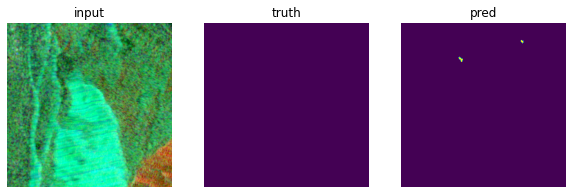

Ep191: tra-> Loss:0.357,Oa:0.976,Miou:0.949, val-> Loss:0.223,Oa:0.929,Miou:0.870,time:2.6s
Ep192: tra-> Loss:0.353,Oa:0.976,Miou:0.954, val-> Loss:0.218,Oa:0.932,Miou:0.875,time:2.6s
Ep193: tra-> Loss:0.349,Oa:0.980,Miou:0.954, val-> Loss:0.215,Oa:0.933,Miou:0.879,time:2.6s
Ep194: tra-> Loss:0.348,Oa:0.981,Miou:0.959, val-> Loss:0.215,Oa:0.932,Miou:0.878,time:2.6s
Ep195: tra-> Loss:0.352,Oa:0.970,Miou:0.948, val-> Loss:0.214,Oa:0.933,Miou:0.879,time:2.6s
Ep196: tra-> Loss:0.349,Oa:0.976,Miou:0.955, val-> Loss:0.214,Oa:0.934,Miou:0.878,time:2.6s
Ep197: tra-> Loss:0.353,Oa:0.975,Miou:0.950, val-> Loss:0.215,Oa:0.933,Miou:0.877,time:2.6s
Ep198: tra-> Loss:0.355,Oa:0.974,Miou:0.939, val-> Loss:0.214,Oa:0.933,Miou:0.879,time:2.6s
Ep199: tra-> Loss:0.351,Oa:0.975,Miou:0.949, val-> Loss:0.213,Oa:0.933,Miou:0.880,time:2.6s
Ep200: tra-> Loss:0.345,Oa:0.982,Miou:0.964, val-> Loss:0.212,Oa:0.934,Miou:0.880,time:2.6s


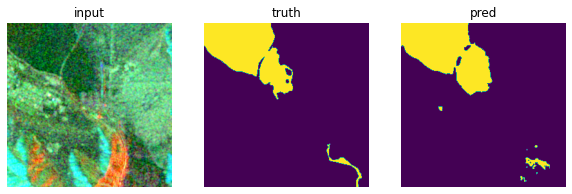

In [8]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce,  
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,   
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [ ]:
# model_name = 'unet_single'
# # model save/load
# model_weights = config.root + '/model/pretrained/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), model_weights)
# model.load_state_dict(torch.load(model_weights))



Error: Kernel is dead

In [10]:
# ## metrics saving
# metrics_path = config.root + '/model/pretrained/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(metrics_path, index=False, sep=',')
# # metrics_df = pd.read_csv(metrics_path)
